In [2]:
!fiftyone plugins download https://github.com/jacobmarks/fiftyone-albumentations-plugin

  135.7Kb [18.2ms elapsed, ? remaining, 7.3Mb/s]    
Skipping existing plugin '@jacobmarks/albumentations_augmentation'


In [3]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.random as four

from LeNet import ModernLeNet5
import numpy as np
from tqdm import tqdm
from PIL import Image

import torch 
import torch.utils.data
import torchvision.transforms.v2 as transforms

import albumentations as A

device = "cpu"

/Users/finnfreiheit/code/hpi/ahocv/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

mnist_data = foz.datasets.load_zoo_dataset("mnist")

Split 'train' already downloaded
Split 'test' already downloaded
You are running the oldest supported major version of MongoDB. Please refer to https://deprecation.voxel51.com for deprecation notices. You can suppress this exception by setting your `database_validation` config parameter to `False`. See https://docs.voxel51.com/user_guide/config.html#configuring-a-mongodb-connection for more information
Loading existing dataset 'mnist'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [3]:
dataset_classes = sorted(mnist_data.distinct("ground_truth.label"))
dataset_classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [4]:
train_val_dataset = foz.load_zoo_dataset("mnist", 
                                         split="train",
                                         dataset_name="mnist_train_val",
                                         persistent=True)

Split 'train' already downloaded
Loading existing dataset 'mnist_train_val'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [13]:
train_val_dataset.untag_samples(["train", "validation"])
four.random_split(train_val_dataset, 
                  {"train": 0.85, "validation":0.15},
                  seed=51)

train_dataset = train_val_dataset.match_tags("train").clone()
val_dataset = train_val_dataset.match_tags("validation").clone()

# Set names for FO datasets using the 'name' property
train_dataset.name = "mnist-training-set"
val_dataset.name = "mnist-validation-set"

# Define persistency
train_dataset.persistent = True
val_dataset.persistent = True

# Verify no overlap between train and validation
train_ids = set(train_dataset.values("id"))
val_ids = set(val_dataset.values("id"))
overlap = train_ids.intersection(val_ids)

ValueError: Dataset name 'mnist-training-set' is not available

In [6]:
def compute_stats_fiftyone(fiftyone_view):
    """
    Compute stats directly from FiftyOne using aggregations.
    Requires images to be loaded as arrays.
    """

    print("Computing image intensity statistics from FiftyOne view...")

    # Get all image filepaths
    filepaths = fiftyone_view.values("filepath")

    # Load all pixel values
    all_pixels = []

    for filepath in tqdm(filepaths):

        try:
            # Load image as grayscale array
            image = Image.open(filepath).convert('L')
            # Scale values to the range [0, 1]
            pixels = np.array(image, dtype=np.float32) / 255.0
            all_pixels.append(pixels.flatten())
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            continue

    # Concatenate all pixel values
    all_pixels = np.concatenate(all_pixels)

    # Compute statistics
    mean = np.mean(all_pixels)
    std = np.std(all_pixels)

    print(f"Computed from {len(filepaths)} images")
    print(f"Total pixels: {len(all_pixels):,}")

    return mean, std

mean_intensity, std_intensity = compute_stats_fiftyone(train_dataset)
f"Mean: {mean_intensity:.4f}, Std: {std_intensity:.4f}"

Computing image intensity statistics from FiftyOne view...


100%|██████████| 51000/51000 [00:03<00:00, 14476.06it/s]


Computed from 51000 images
Total pixels: 39,984,000


'Mean: 0.1318, Std: 0.3075'

In [7]:
image_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((mean_intensity,), (std_intensity,))
])

In [8]:
label_map = { string_label: index for index, string_label in enumerate(dataset_classes)}

In [9]:
from CustomTorchImageDataset import CustomTorchImageDataset

torch_train_set = CustomTorchImageDataset(train_dataset, label_map=label_map, image_transforms=image_transforms)
torch_val_set = CustomTorchImageDataset(val_dataset, label_map=label_map, image_transforms=image_transforms)

CustomTorchImageDataset initialized with 51000 samples.
CustomTorchImageDataset initialized with 9000 samples.


In [14]:
import os
from reproducibility import create_deterministic_training_dataloader


# Create PyTorch DataLoaders 
batch_size = 64
num_workers = 0

train_loader = create_deterministic_training_dataloader(
    torch_train_set,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    torch_val_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=num_workers,
    pin_memory=True
)


print("Train and validation DataLoaders created successfully.")
print(f"Train DataLoader has {len(train_loader)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")

All random seeds set to 51 for reproducibility
Train and validation DataLoaders created successfully.
Train DataLoader has 797 batches.
Validation DataLoader has 141 batches.


In [16]:
from torch.optim import Adam
import torch.nn as nn

model = ModernLeNet5()
# Define the optimizer (variant of stochastic gradient descent)
optimizer = Adam(model.parameters(),
                 lr=0.003, betas=(0.9, 0.999),
                 eps=1e-08, weight_decay=0)
ce_loss = nn.CrossEntropyLoss()

def train_epoch(model, train_loader):
  batch_losses = []
  model.train()
  for images, labels in tqdm(train_loader, desc="Training: "):
      #import pdb; pdb.set_trace()

      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = ce_loss(logits, labels)
      # Clear gradients from previous iteration (PyTorch accumulates by default)
      optimizer.zero_grad()
      # Computes the gradients with backpropagation
      loss_value.backward()
      # Updates the weights
      optimizer.step()

      batch_losses.append(loss_value.item())

  train_loss = np.mean(batch_losses)
  return train_loss


def val_epoch(model, val_loader):
  batch_losses = []
  model.eval()
  with torch.inference_mode():
    for images, labels in tqdm(val_loader, desc="Validation: "):
      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = ce_loss(logits, labels)
      batch_losses.append(loss_value.item())
  val_loss = np.mean(batch_losses)
  return val_loss


In [17]:
from pathlib import Path

num_epochs = 5
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model = None

# Define the path to save the model within your hard-drive
path = Path(os.getcwd()) # Feel free to change the path

model_save_path = path / 'best_lenet.pth'

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader)
    val_loss = val_epoch(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        # Save the best model
        torch.save(best_model.state_dict(), model_save_path)
        print('Found and saved better weights for the model')

Validation: 100%|██████████| 141/141 [00:01<00:00, 93.25it/s] 


Epoch 1/5 - Train Loss: 0.2526 - Val Loss: 0.0781
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 100.81it/s]


Epoch 2/5 - Train Loss: 0.0933 - Val Loss: 0.0636
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 102.61it/s]


Epoch 3/5 - Train Loss: 0.0722 - Val Loss: 0.0665


Validation: 100%|██████████| 141/141 [00:01<00:00, 103.24it/s]


Epoch 4/5 - Train Loss: 0.0586 - Val Loss: 0.0592
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 101.14it/s]

Epoch 5/5 - Train Loss: 0.0525 - Val Loss: 0.0573
Found and saved better weights for the model


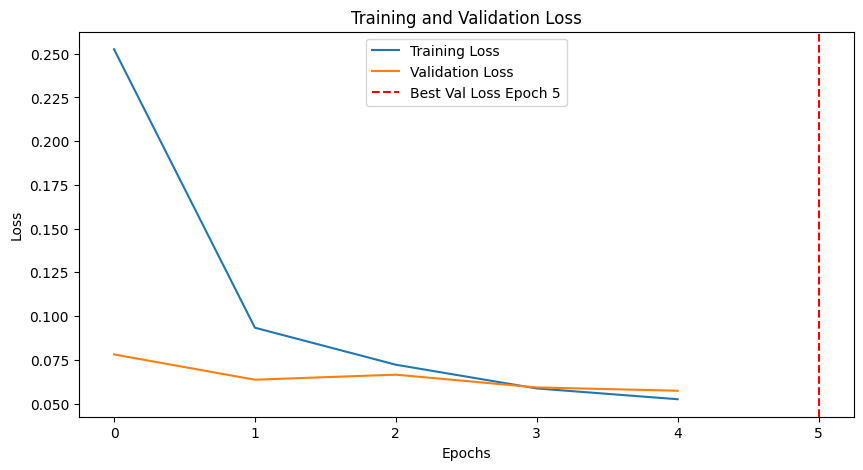

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Find the epoch with the best validation loss
best_epoch = np.argmin(val_losses) + 1 # Add 1 because epochs are 1-indexed

# Add a vertical red line at the epoch with the best validation loss
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Val Loss Epoch {best_epoch}')
plt.legend()

plt.show()

# Applying the Model


In [19]:
# Define the path where the best model was saved
path = Path(os.getcwd())
model_save_path = path / 'best_lenet.pth'

# Instantiate a new model with the same architecture
# Make sure you use the same model class that was trained
loaded_model = ModernLeNet5()

# Load the saved state dictionary into the new model instance
# Make sure the model is on the correct device (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))

# Move the model to the device
loaded_model = loaded_model.to(device)

# Set the model to evaluation mode
loaded_model.eval()

print(f"Model loaded successfully from {model_save_path}")
print(f"Model is on device: {next(loaded_model.parameters()).device}")

Model loaded successfully from /Users/finnfreiheit/code/hpi/ahocv/best_lenet.pth
Model is on device: cpu


In [20]:
import torch.nn.functional as Fun
## Apply best_model to the test set, store logits and confidence

# Create a PyTorch Dataset for the test set
torch_test_set = CustomTorchImageDataset(mnist_data,
                                      label_map=label_map, # Use the same label map as training
                                      image_transforms=image_transforms) # Use the same transforms

# Create a PyTorch DataLoader for the test set
test_loader = torch.utils.data.DataLoader(
    torch_test_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle test data
    num_workers=num_workers,
    pin_memory=True
)

print("Test DataLoader created successfully.")
print(f"Test DataLoader has {len(test_loader)} batches.")

# Set the loaded model to evaluation mode
loaded_model.eval()

# Lists to store predictions and logits
predictions = []
all_logits = []

# Run inference on the test set
print("Applying best LeNet model to the test set...")
with torch.inference_mode(): # Disable gradient calculation
    for images, _ in tqdm(test_loader):
        images = images.to(device)

        # Forward pass to get logits
        logits = loaded_model(images)
        all_logits.append(logits.cpu().numpy()) # Store logits

        # Get predicted class indices
        _, predicted = torch.max(logits.data, 1)
        predictions.extend(predicted.cpu().numpy()) # Store predictions

# Concatenate logits from all batches
all_logits = np.concatenate(all_logits, axis=0)

print("Inference on test set complete.")
print(f"Shape of collected logits: {all_logits.shape}")
print(f"Number of collected predictions: {len(predictions)}")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications...")

for i, sample in enumerate(mnist_data):
    # Get the predicted class index and corresponding class name
    predicted_idx = predictions[i]
    predicted_label = dataset_classes[predicted_idx]

    # Get logits for this sample
    sample_logits = all_logits[i]

    # Calculate confidence scores (softmax applied to logits)
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])

    # Create FiftyOne Classification object with prediction
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()  # Store raw logits
    )

    # Store the Classification object in the sample
    sample["lenet_classification"] = classification

    sample.save()




CustomTorchImageDataset initialized with 70000 samples.
Test DataLoader created successfully.
Test DataLoader has 1094 batches.
Applying best LeNet model to the test set...


  0%|          | 0/1094 [00:00<?, ?it/s]/Users/finnfreiheit/code/hpi/ahocv/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 1094/1094 [00:10<00:00, 103.99it/s]


Inference on test set complete.
Shape of collected logits: (70000, 10)
Number of collected predictions: 70000
Storing predictions and logits as FiftyOne Classifications...


In [22]:
print("\n=== Verification ===")
sample = mnist_data.first()
print(f"Sample prediction type: {type(sample.lenet_classification)}")
print(f"Sample prediction: {sample.lenet_classification}")
print(f"Prediction label: {sample.lenet_classification.label}")
print(f"Prediction confidence: {sample.lenet_classification.confidence}")
print(f"Prediction logits shape: {len(sample.lenet_classification.logits)}")



=== Verification ===
Sample prediction type: <class 'fiftyone.core.labels.Classification'>
Sample prediction: <Classification: {
    'id': '691f1b1cbbc5fd03b3bc8c24',
    'tags': [],
    'label': '5 - five',
    'confidence': 0.5295537710189819,
    'logits': array([-12.73950768,  -5.98446703,  -7.94948292,   7.32142067,
            -7.65888739,   7.4399085 , -10.22210979,  -7.30716467,
            -5.43234777,  -1.63227355]),
}>
Prediction label: 5 - five
Prediction confidence: 0.5295537710189819
Prediction logits shape: 10


In [23]:
session = fo.launch_app(mnist_data, auto=False)
session.url

Session launched. Run `session.show()` to open the App in a cell output.


'http://localhost:5151/'

In [24]:
from fiftyone import ViewField as F

# Create a view showing only LeNet's misclassifications
misclassified_view = mnist_data.match(
    F("lenet_classification.label") != F("ground_truth.label")
)
print(f"Misclassified samples: {len(misclassified_view)} samples")

Misclassified samples: 635 samples


## Change Groundtruth Label of misclassified samples to IDK 

In [25]:
misclassified_view.set_field("ground_truth.label", "IDK").save()  # this writes changes back to the underlying dataset

In [26]:
misclassified_view

Dataset:     mnist
Media type:  image
Num samples: 635
Sample fields:
    id:                   fiftyone.core.fields.ObjectIdField
    filepath:             fiftyone.core.fields.StringField
    tags:                 fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:             fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:           fiftyone.core.fields.DateTimeField
    last_modified_at:     fiftyone.core.fields.DateTimeField
    ground_truth:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    clip_embeddings:      fiftyone.core.fields.VectorField
    lenet_classification: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
View stages:
    1. Match(filter={'$expr': {'$ne': [...]}})

In [27]:
new_dataset_classes = sorted(mnist_data.distinct("ground_truth.label"))
new_dataset_classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine',
 'IDK']

## Train new Model - with IDK Class

In [28]:
new_train_val_dataset = foz.load_zoo_dataset("mnist", 
                                         split="train",
                                         dataset_name="mnist_train_val",
                                         persistent=True)

Split 'train' already downloaded
Loading existing dataset 'mnist_train_val'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [ ]:
new_train_val_dataset.untag_samples(["train", "validation"])
four.random_split(new_train_val_dataset, 
                  {"train": 0.85, "validation":0.15},
                  seed=51)

new_train_dataset = new_train_val_dataset.match_tags("train").clone()
new_val_dataset = new_train_val_dataset.match_tags("validation").clone()

# Set names for FO datasets using the 'name' property
new_train_dataset.name = "new_mnist-training-set"
new_val_dataset.name = "new_mnist-validation-set"

# Define persistency
new_train_dataset.persistent = True
new_val_dataset.persistent = True


new_label_map = { string_label: index for index, string_label in enumerate(new_dataset_classes)}


new_torch_train_set = CustomTorchImageDataset(new_train_dataset, label_map=new_label_map, image_transforms=image_transforms)
new_torch_val_set = CustomTorchImageDataset(new_val_dataset, label_map=new_label_map, image_transforms=image_transforms)

# Create PyTorch DataLoaders 
batch_size = 64
num_workers = 0

new_train_loader = create_deterministic_training_dataloader(
    new_torch_train_set,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

new_val_loader = torch.utils.data.DataLoader(
    new_torch_val_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=num_workers,
    pin_memory=True
)

print("Train and validation DataLoaders created successfully.")
print(f"Train DataLoader has {len(new_train_loader)} batches.")
print(f"Validation DataLoader has {len(new_val_loader)} batches.")

model = ModernLeNet5()
# Define the optimizer (variant of stochastic gradient descent)
optimizer = Adam(model.parameters(),
                 lr=0.003, betas=(0.9, 0.999),
                 eps=1e-08, weight_decay=0)
ce_loss = nn.CrossEntropyLoss()



num_epochs = 5
new_train_losses = []
new_val_losses = []

new_best_val_loss = float('inf')
new_best_model = None

# Define the path to save the model within your hard-drive
path = Path(os.getcwd()) # Feel free to change the path

model_save_path = path / 'new_best_lenet.pth'

for epoch in range(num_epochs):
    new_train_loss = train_epoch(model, new_train_loader)
    new_val_loss = val_epoch(model, new_val_loader)
    new_train_losses.append(new_train_loss)
    new_val_losses.append(new_val_loss)


    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {new_train_loss:.4f} - Val Loss: {new_val_loss:.4f}")

    if new_val_loss < new_best_val_loss:
        new_best_val_loss = new_val_loss
        new_best_model = model
        # Save the best model
        torch.save(new_best_model.state_dict(), model_save_path)
        print('Found and saved better weights for the model')

CustomTorchImageDataset initialized with 51000 samples.
CustomTorchImageDataset initialized with 9000 samples.
Train and validation DataLoaders created successfully.
Train DataLoader has 797 batches.
Validation DataLoader has 141 batches.


Training:   0%|          | 0/797 [00:00<?, ?it/s]/Users/finnfreiheit/code/hpi/ahocv/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Validation: 100%|██████████| 141/141 [00:01<00:00, 93.66it/s] 


Epoch 1/5 - Train Loss: 0.2423 - Val Loss: 0.0834
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 96.83it/s] 


Epoch 2/5 - Train Loss: 0.0883 - Val Loss: 0.0720
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 98.73it/s] 


Epoch 3/5 - Train Loss: 0.0676 - Val Loss: 0.0649
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 96.53it/s] 


Epoch 4/5 - Train Loss: 0.0552 - Val Loss: 0.0875


Validation: 100%|██████████| 141/141 [00:01<00:00, 98.34it/s] 

Epoch 5/5 - Train Loss: 0.0518 - Val Loss: 0.0691


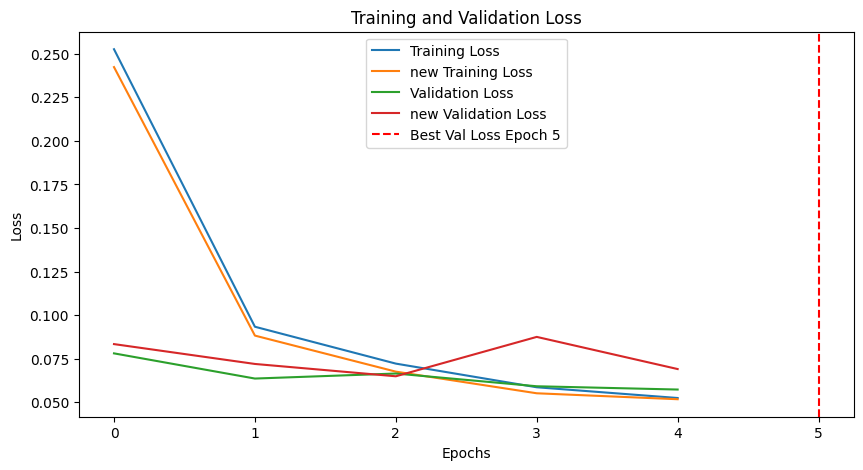

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(new_train_losses, label="new Training Loss")
plt.plot(val_losses, label='Validation Loss')
plt.plot(new_val_losses, label="new Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Find the epoch with the best validation loss
best_epoch = np.argmin(val_losses) + 1 # Add 1 because epochs are 1-indexed

# Add a vertical red line at the epoch with the best validation loss
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Val Loss Epoch {best_epoch}')
plt.legend()

plt.show()

# Applying the new Model

In [33]:
# Define the path where the best model was saved
path = Path(os.getcwd())
model_save_path = path / 'new_best_lenet.pth'

# Instantiate a new model with the same architecture
# Make sure you use the same model class that was trained
loaded_model = ModernLeNet5()

# Load the saved state dictionary into the new model instance
# Make sure the model is on the correct device (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))

# Move the model to the device
loaded_model = loaded_model.to(device)

# Set the model to evaluation mode
loaded_model.eval()

print(f"Model loaded successfully from {model_save_path}")
print(f"Model is on device: {next(loaded_model.parameters()).device}")

Model loaded successfully from /Users/finnfreiheit/code/hpi/ahocv/new_best_lenet.pth
Model is on device: cpu


In [34]:
import torch.nn.functional as Fun
## Apply best_model to the test set, store logits and confidence

# Create a PyTorch Dataset for the test set
torch_test_set = CustomTorchImageDataset(mnist_data,
                                      label_map=new_label_map, # Use the same label map as training
                                      image_transforms=image_transforms) # Use the same transforms

# Create a PyTorch DataLoader for the test set
test_loader = torch.utils.data.DataLoader(
    torch_test_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle test data
    num_workers=num_workers,
    pin_memory=True
)

print("Test DataLoader created successfully.")
print(f"Test DataLoader has {len(test_loader)} batches.")

# Set the loaded model to evaluation mode
loaded_model.eval()

# Lists to store predictions and logits
predictions = []
all_logits = []

# Run inference on the test set
print("Applying best LeNet model to the test set...")
with torch.inference_mode(): # Disable gradient calculation
    for images, _ in tqdm(test_loader):
        images = images.to(device)

        # Forward pass to get logits
        logits = loaded_model(images)
        all_logits.append(logits.cpu().numpy()) # Store logits

        # Get predicted class indices
        _, predicted = torch.max(logits.data, 1)
        predictions.extend(predicted.cpu().numpy()) # Store predictions

# Concatenate logits from all batches
all_logits = np.concatenate(all_logits, axis=0)

print("Inference on test set complete.")
print(f"Shape of collected logits: {all_logits.shape}")
print(f"Number of collected predictions: {len(predictions)}")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications...")

for i, sample in enumerate(mnist_data):
    # Get the predicted class index and corresponding class name
    predicted_idx = predictions[i]
    predicted_label = dataset_classes[predicted_idx]

    # Get logits for this sample
    sample_logits = all_logits[i]

    # Calculate confidence scores (softmax applied to logits)
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])

    # Create FiftyOne Classification object with prediction
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()  # Store raw logits
    )

    # Store the Classification object in the sample
    sample["lenet_classification"] = classification

    sample.save()




CustomTorchImageDataset initialized with 70000 samples.
Test DataLoader created successfully.
Test DataLoader has 1094 batches.
Applying best LeNet model to the test set...


  0%|          | 0/1094 [00:00<?, ?it/s]/Users/finnfreiheit/code/hpi/ahocv/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 1094/1094 [00:09<00:00, 115.29it/s]


Inference on test set complete.
Shape of collected logits: (70000, 10)
Number of collected predictions: 70000
Storing predictions and logits as FiftyOne Classifications...


In [35]:
print("\n=== Verification ===")
sample = mnist_data.first()
print(f"Sample prediction type: {type(sample.lenet_classification)}")
print(f"Sample prediction: {sample.lenet_classification}")
print(f"Prediction label: {sample.lenet_classification.label}")
print(f"Prediction confidence: {sample.lenet_classification.confidence}")
print(f"Prediction logits shape: {len(sample.lenet_classification.logits)}")



=== Verification ===
Sample prediction type: <class 'fiftyone.core.labels.Classification'>
Sample prediction: <Classification: {
    'id': '691f2692bbc5fd03b3bd9d9c',
    'tags': [],
    'label': '5 - five',
    'confidence': 0.9999130964279175,
    'logits': array([-12.44466686, -14.68557072, -16.42384911,   3.91405153,
           -16.13043976,  13.2641716 , -12.15734196, -13.23921299,
            -7.78015518,  -5.30317736]),
}>
Prediction label: 5 - five
Prediction confidence: 0.9999130964279175
Prediction logits shape: 10


In [36]:
from fiftyone import ViewField as F

# Create a view showing only LeNet's misclassifications
misclassified_view = mnist_data.match(
    F("lenet_classification.label") != F("ground_truth.label")
)
print(f"Misclassified samples: {len(misclassified_view)} samples")

Misclassified samples: 1250 samples


In [38]:
session.refresh()
session.url

'http://localhost:5151/'

In [1]:
mnist_data

NameError: name 'mnist_data' is not defined

# Publish to Huggingface

In [ ]:
# 1. Convert to Dataset 

torch_mnist_data = CustomTorchImageDataset(mnist_data, image_transforms=image_transforms, label_map=new_label_map)


CustomTorchImageDataset initialized with 70000 samples.


In [7]:
type(mnist_data)

fiftyone.core.dataset.Dataset

In [11]:

export_dir = "curated_data"
mnist_data.export(
    export_dir="curated_data",
    dataset_type=fo.types.ImageClassificationDirectoryTree,
    label_field="ground_truth",
)


 100% |█████████████| 70000/70000 [24.1s elapsed, 0s remaining, 2.9K samples/s]      
